In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

# Practical Session - Planning in bandits/MDP

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm

from forban import *
from forban.bandits import NormalBandit, Normal
from forban.sequentialg import SequentiAlg
from forban.utils import *

# Part I - Best Arm Identification

# Bandit environment, how to?

## Distributions - Arms

In [3]:
mean_1 = 0.
mean_2 = 1.
normal_1 = Normal(mean_1)
normal_2 = Normal(mean_2)
sample_1 = normal_1.sample()
sample_2 = normal_2.sample()
means = [mean_1, mean_2]
print(f"A sample from a normal distribution with mean {mean_1} and standard deviation 1 is {sample_1:.3f}")
print(f"A sample from a normal distribution with mean {mean_2} and standard deviation 1 is {sample_2:.3f}")

A sample from a normal distribution with mean 0.0 and standard deviation 1 is 0.567
A sample from a normal distribution with mean 1.0 and standard deviation 1 is 1.533


## Bandit instance

In [4]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])
print(f"A bandit instance is {bandit_instance}")

A bandit instance is Bandit([Normal (mean=0.100, std=1.000), Normal (mean=0.200, std=1.000), Normal (mean=0.320, std=1.000), Normal (mean=0.240, std=1.000), Normal (mean=0.220, std=1.000)])


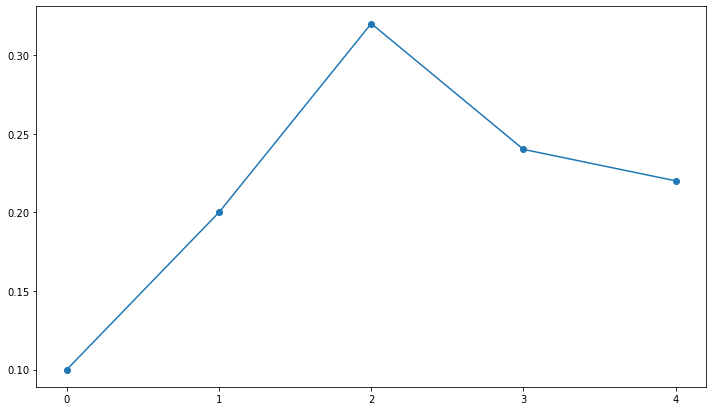

In [5]:
plot_bandit(bandit_instance)

## SequentiAlg class

In [6]:
alg = SequentiAlg(bandit_instance)
print(alg)

Sequential algorithm - time step = 0
  Normal (mean=0.100, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.200, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.320, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.240, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.220, std=1.000) : est. mean = 0.000 - nbr. pulls = 0



In [7]:
# Play arm 0 ...
alg.pull(0)
print(alg)

# ... then play arm 1
alg.pull(1)
print(alg)

Sequential algorithm - time step = 1
  Normal (mean=0.100, std=1.000) : est. mean = 0.039 - nbr. pulls = 1
  Normal (mean=0.200, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.320, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.240, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.220, std=1.000) : est. mean = 0.000 - nbr. pulls = 0

Sequential algorithm - time step = 2
  Normal (mean=0.100, std=1.000) : est. mean = 0.039 - nbr. pulls = 1
  Normal (mean=0.200, std=1.000) : est. mean = 1.134 - nbr. pulls = 1
  Normal (mean=0.320, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.240, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.220, std=1.000) : est. mean = 0.000 - nbr. pulls = 0



In [8]:
print('time: ', alg.time)
print('Number of pulls: ', alg.nbr_pulls)
print('Empirical means: ', alg.means)

time:  2
Number of pulls:  [1 1 0 0 0]
Empirical means:  [0.03917081 1.13438969 0.         0.         0.        ]


In [9]:
# Run the algorithm for 1000 steps.
# By default, the choose_an_arm method implements uniform random selection among arms.
# You will implement other selection methods in the following.
alg.fit(1000)
print(alg)

Sequential algorithm - time step = 1000
  Normal (mean=0.100, std=1.000) : est. mean = 0.113 - nbr. pulls = 225
  Normal (mean=0.200, std=1.000) : est. mean = 0.285 - nbr. pulls = 176
  Normal (mean=0.320, std=1.000) : est. mean = 0.511 - nbr. pulls = 202
  Normal (mean=0.240, std=1.000) : est. mean = 0.241 - nbr. pulls = 211
  Normal (mean=0.220, std=1.000) : est. mean = 0.299 - nbr. pulls = 186



### Question 1

What are the three main parts of an exploration algorithm that aims to identify the best arm (*i.e.*, the arm having the largest mean)?

### Exploration class template

In [10]:
class Exploration(SequentiAlg):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stopping criterion': None }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.stopping_criterion = params.get('stopping criterion', None)
        
    def compute_indices(self):
        pass
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        pass
    
    def stop(self):
        pass
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

## Template for doing experiments

In [11]:
class Experiment:
    def __init__(self, sequential_algorithms, bandit,
                 statistics={'distance':True, 'proba':True, 'pulls':True}):
        assert len(sequential_algorithms) > 0
        self.algorithms = sequential_algorithms
        self.bandit = bandit
        self.nbr_algo = len(sequential_algorithms)
        self.algo_idx = 0
        self.statistics = {}
        self.nbr_exp = None
        for algo_idx, algo in enumerate(self.algorithms):
            self.statistics[algo_idx] = {'name': algo.name}
            for s in statistics.items():
                if s[1]:
                    self.statistics[algo_idx][s[0]] = None
        stats = self.statistics[0].keys()
        self.stats = stats

    def run(self, nbr_exp=500):
        self.nbr_exp = nbr_exp
        for algo_idx, algo in enumerate(self.algorithms):
            reco_arms = np.zeros(nbr_exp+self.bandit.nbr_arms, int)
            delta = np.zeros(nbr_exp+self.bandit.nbr_arms)
            pulls = np.zeros(nbr_exp, int)
            for i in tqdm(range(nbr_exp)):
                algo.reset()
                algo.run()
                
                reco_arms[i] = algo.recommendation()
                delta[i] = self.bandit.regrets[reco_arms[i]]
                pulls[i] = np.sum(algo.nbr_pulls)
            
            reco_arms[nbr_exp:] = np.arange(self.bandit.nbr_arms)
            delta[nbr_exp:] = self.bandit.regrets
            for k in self.stats:
                if k == 'distance':
                    self.statistics[algo_idx][k] = delta.copy()
                elif k == 'proba':
                    self.statistics[algo_idx][k] = reco_arms.copy()
                elif k == 'pulls':
                    self.statistics[algo_idx]['pulls'] = pulls.copy()
                    
    def plot(self, normalisation=False):
        exp_info = f"Nbr. of experiments = {self.nbr_exp}"
        ticks = np.arange(self.bandit.nbr_arms)
        if 'proba' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arm", fontsize=14)
            plt.xticks(ticks, [str(i) for i in range(self.bandit.nbr_arms)])
            
            n = self.nbr_algo
            w = 1/(2*n)
            
            for i, algo_stats in enumerate(self.statistics.values()):
                name = algo_stats['name']
                _, hist = np.unique(algo_stats['proba'], return_counts=True)
                hist = hist - np.ones(self.bandit.nbr_arms, int)
                if normalisation:
                    hist = hist / self.nbr_exp
                    ax = plt.gca()
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
                t = ticks + w*(i - (n-1)/2)
                plt.bar(t, hist, width=w, label=name, alpha=0.5)
    
            plt.legend()
            plt.show()
        
        ticks = np.sort(self.bandit.regrets)
        if 'distance' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation regret\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arm - regret", fontsize=14)
            idxs = np.argsort(self.bandit.regrets)
            tmp = self.bandit.regrets[idxs]
            tmp = np.abs(tmp[1:] - tmp[:-1])
            w = np.unique(tmp)
            w = w[w > 0]
            
            n = self.nbr_algo
            w = w[0] / (2*n)
            
            plt.xticks(ticks, [f"{idxs[i]} - {self.bandit.regrets[idxs[i]]:.3f}" for i in range(self.bandit.nbr_arms)])

            for i, algo_stats in enumerate(self.statistics.values()):
                name = algo_stats['name']
                delta = algo_stats['distance']
                _, hist = np.unique(delta, return_counts=True)
                hist = hist - np.ones(self.bandit.nbr_arms, int)
                if normalisation:
                    hist = hist / self.nbr_exp
                    ax = plt.gca()
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
                t = ticks + w*(i - (n-1)/2)
                plt.bar(t, hist, width=w, label=name, alpha=0.5)
    
            plt.legend()
            plt.show()
            
        if 'pulls' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of number of pulls\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Number of pulls", fontsize=14)
            
            w = np.max([np.max(algo_stats['pulls']) for algo_stats in self.statistics.values()]) / 12
            
            color = plt.cm.rainbow(np.linspace(0, 1, self.nbr_algo))
            
            for i, algo_stats in enumerate(self.statistics.values()):
                name = algo_stats['name']
                p = plt.hist(algo_stats['pulls'], width=w, label=name, alpha=0.5, bins=10, color=color[i])
                plt.axvline(x=np.mean(algo_stats['pulls']), linestyle='dashed', label=name + ' mean pulls', color=color[i])
            plt.legend()
            plt.show()

## Warm-up: uniform exploration

### Question 2
Using the `Exploration` class, implement an exploration algorithm with uniform allocation. Test different recommendation rules on at least two different bandit problems.

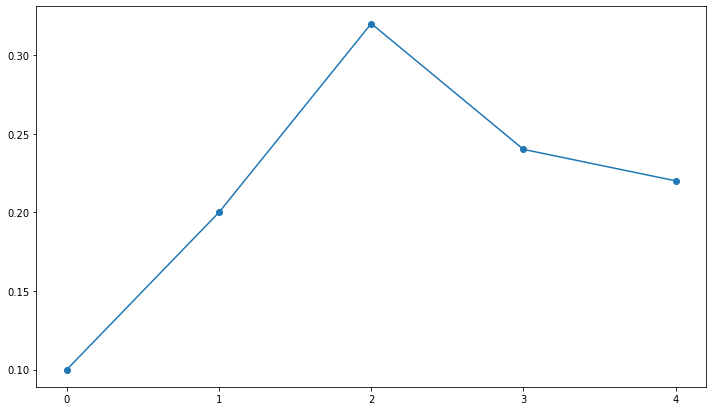

In [12]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])
plot_bandit(bandit_instance)

In [13]:
class ExplorationUniform(Exploration):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stopping criterion': 500 }):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stopping_criterion = params['stopping criterion']
        
    def compute_indices(self):
        self.indices = np.random.randn(self.bandit.nbr_arms)
        # self.indices = - self.nbr_pulls
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.means)
    
    def stop(self):
        return self.time > self.stopping_criterion
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()

In [14]:
uniform_1 = ExplorationUniform(
    bandit_instance, 
    name="Exploration 200",
    params={'init': 0, 'stopping criterion': 200}
)

In [15]:
expe = Experiment(
    [uniform_1],  # add more algorithms?
    bandit_instance
)

In [16]:
expe.run(200)

  0%|          | 0/200 [00:00<?, ?it/s]

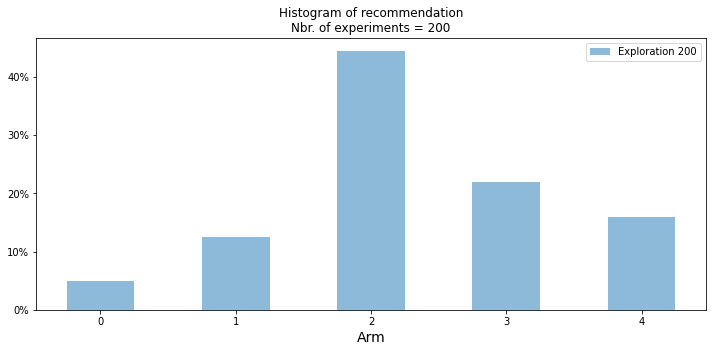

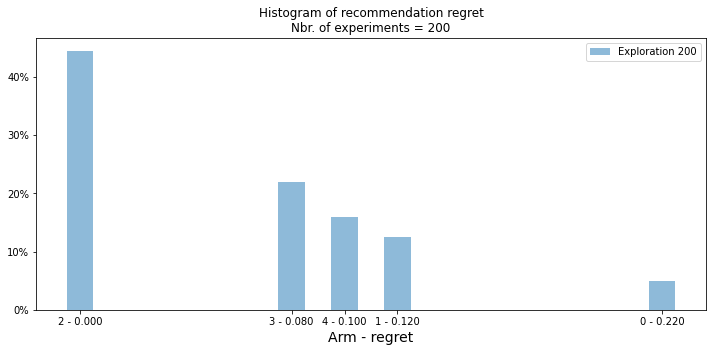

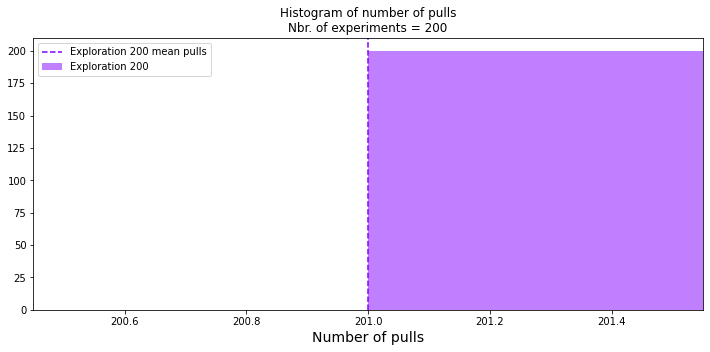

In [17]:
expe.plot(True)

## Fixed budget setting

### Question 3

Recall what the UCB algorithm is for cumulative regret. Derive a **sampling rule** for best arm identification inspired by UCB.

Using the `Exploration` class, implement this idenfication algorithm. Test different **recommendation rules** on different bandit problems.

In [18]:
class ExplorationUCB(Exploration):
    def __init__(self, bandit, name="ExplorationUCB", params={'init': 0, 'stopping criterion': 500, 'alpha': 1.0, 'inv_delta': lambda t: (t + 1) ** 2 }):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stopping_criterion = params['stopping criterion']
        self.alpha = params['alpha']
        self.inv_delta = params['inv_delta']
        
    def compute_indices(self):
        if self.all_selected :
            self.indices = self.means + self.alpha * np.sqrt(
                np.log(self.inv_delta(self.time)) / (2 * self.nbr_pulls)
            )
        else :
            self.indices = [
                np.inf if self.nbr_pulls[arm] == 0 else self.means[arm] + self.alpha * np.sqrt(
                    np.log(self.inv_delta(self.time)) / (2 * self.nbr_pulls[arm])
                ) for arm in range(self.bandit.nbr_arms)
            ]
                
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.means)
    
    def stop(self):
        return self.time > self.stopping_criterion
    
    def run(self):
        while not self.stop(): 
            self.sampling()
            self.recommendation()

In [19]:
ucb_1 = ExplorationUCB(
    bandit_instance, 
    name="ExplorationUCB_1", 
    params={
        'init': 0, 
        'stopping criterion': 500, 
        'alpha': 1.0,
        'inv_delta': lambda t: (t + 1) ** 2,
    }
)

# More exploration
ucb_2 = ExplorationUCB(
    bandit_instance, 
    name="ExplorationUCB_2", 
    params={
        'init': 0, 
        'stopping criterion': 500, 
        'alpha': 2.0,
        'inv_delta': lambda t: (t + 1) ** 2,
    }
)

In [20]:
expe = Experiment(
    [ucb_1, ucb_2],
    bandit_instance
)

In [21]:
expe.run(200)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

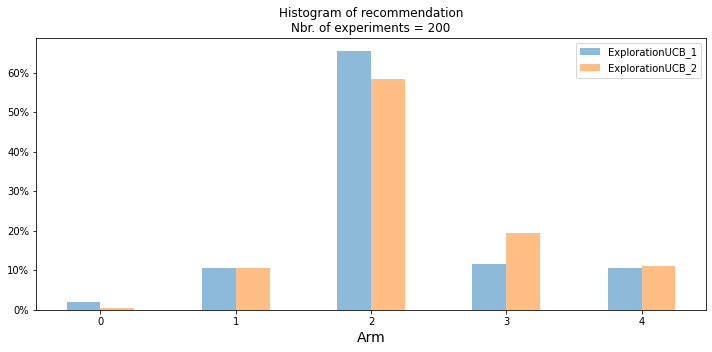

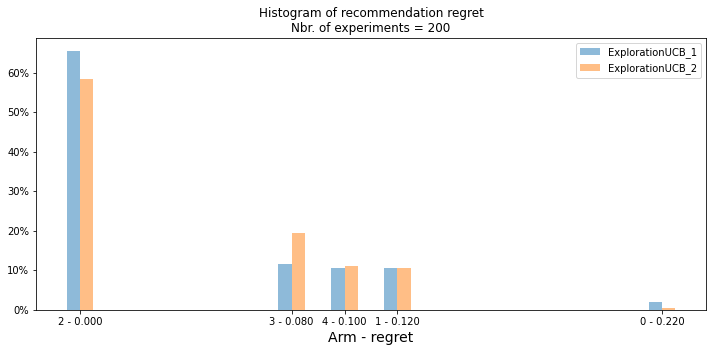

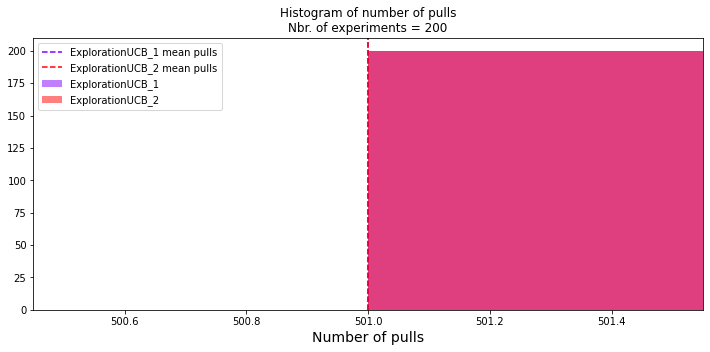

In [22]:
expe.plot(True)

### Comments

UCB seems to identify the best arm but is not significantly more accurate than uniform sampling (in fact it can be beaten by it).

### Question 4.1

Relate the *simple regret* of the exploration strategy UCB+Empirical Distribution of Plays to the *cumulative regret* of UCB.

### Question 4.2

How good is UCB? How does it compare to uniform exploration? What is the influence of the various parameters? Compare the different recommendation rule.

### Question 5
Using the `Exploration` class, implement the sequential halving algorithm with a fixed budget. Test it on different bandit problems.

In [24]:
class ExplorationHalf(Exploration):
    def __init__(self, bandit, name="ExplorationHalf", params={'init': 0, 'stopping criterion': 500}):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.stopping_criterion = params['stopping criterion']
        self.log_nbr_arms = np.ceil(np.log2(float(self.bandit.nbr_arms)))
        self.frac = self.stopping_criterion / self.log_nbr_arms
        self.candidates = np.array(range(self.bandit.nbr_arms))
        self.nbr_arms = self.bandit.nbr_arms
        self.tt = 0
        self.idx = 0

    def sampling(self):
        if self.tt >= np.floor(self.frac / self.nbr_arms):
            self.tt = 0
            self.idx += 1
        
        if self.idx >= self.nbr_arms:
            self.idx = 0
            self.nbr_arms = int(np.ceil(self.nbr_arms / 2))
            idxe = np.argpartition(-self.means[self.candidates], kth=self.nbr_arms)
            self.candidates = self.candidates[idxe]
            
        arm = self.candidates[self.idx]        
        _ = self.pull(arm)
        self.tt += 1
    
    def recommendation(self):
        return randamax(self.means)
    
    def stop(self):
        return self.time > self.stopping_criterion
    
    def run(self):
        while not self.stop(): 
            self.sampling()
            self.recommendation()

In [25]:
sequential_halving_1 = ExplorationHalf(
    bandit_instance, 
    name="ExplorationHalf_1", 
    params={
        'init': 0, 
        'stopping criterion': 500,
    }
)

sequential_halving_2 = ExplorationHalf(
    bandit_instance, 
    name="ExplorationHalf_2", 
    params={
        'init': 0, 
        'stopping criterion': 1500,
    }
)

In [26]:
expe = Experiment([sequential_halving_1, sequential_halving_2], bandit_instance)

In [27]:
expe.run(200)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

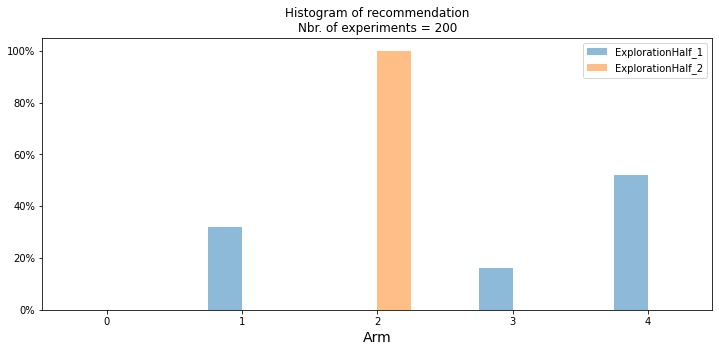

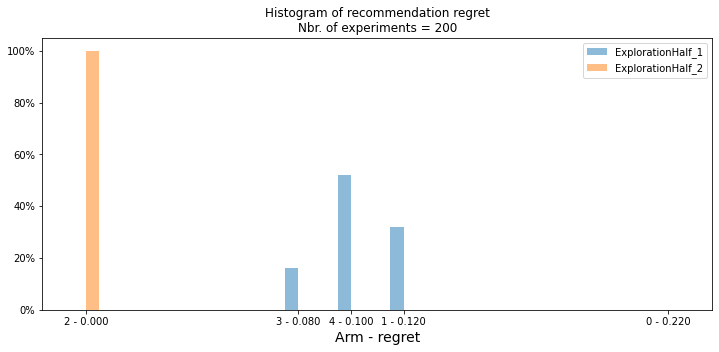

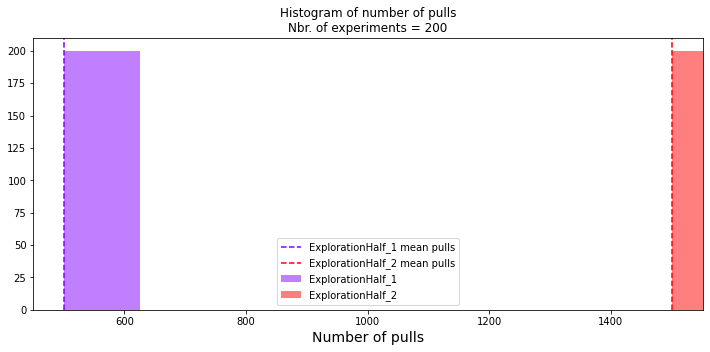

In [28]:
expe.plot(True)

### Question 6

How good is sequential halving? Cite at least one drawback compared to UCB.

Sequential Halving works really well... if the horizon is large enough. Also, contrary to UCB, it is not adaptive: if the best arm gets discarded during the halving process, it cannot be recovered later! On average, this should not happen too often though, hence the regret guarantee for sequential halving.

## Fixed confidence setting

Fixed confidence algorithms return a best arm recommendation after a **variable** number of steps $\tau_{\delta}$, so that the probability that the recommendation is correct is at least $1-\delta$.

We will derive such an algorithm in the case of $\textbf{K=2}$ arms with Gaussian distributions $\mathcal{N}(\mu_1, \sigma^2)$ and $\mathcal{N}(\mu_2, \sigma^2)$ ($\sigma$ is known), in which case all calculations are explicit.

Let $\mu = \begin{pmatrix} \mu_1 \\ \mu_2\end{pmatrix}\in\mathbb{R}^2$ the vector of means. Assume for simplicity that $1$ is the optimal arm, i.e $\mu_1 > \mu_2$. We define the set of *alternatives* to $\mu$ as $\text{Alt}(\mu) = \{ \lambda\in\mathbb{R}^2, \lambda_1 < \lambda_2\}$, i.e the set of mean vectors such that in the bandit they represent, arm $1$ is *not* optimal.

An important quantity to analyze best-arm-identification algorithms is the **characteristic time**:
$$
T_*(\mu)^{-1} = \max_{w\in[0, 1]} \inf_{\lambda\in\text{Alt}(\mu)} w \text{kl}(\mu_1, \lambda_1) + (1-w) \text{kl}(\mu_2, \lambda_2),
$$
where $\text{kl}(\mu_k, \lambda_k)$ is Kullback-Leibler divergence between $\mathcal{N}(\mu_k, \sigma^2)$ and $\mathcal{N}(\lambda_k, \sigma^2)$.

### Question 7.1
Recall the expression of the KL divergence $kl(\mu_k, \lambda_k)$. Have you seen the quantity $T_*(\mu)$ in class?

Answer: $kl(\mu_k, \lambda_k) = \frac{(\mu_k - \lambda_k)^2}{2\sigma^2}$.

Let's have a look at the $w\in[0, 1]$ for which the maximum is attained in the definition of $T_*(\mu)$. 

The vector $\begin{pmatrix}w_*(\mu)\\1-w_*(\mu)\end{pmatrix}$ is called the vector of **optimal allocation**. In theory, a *good* identification algorithm should select arm $1$ around $w_*(\mu)$ fraction of the time, and arm $2$ around $1-w_*(\mu)$ fraction of the time. 

### Question 7.2 Compute the optimal allocation

For $w\in(0,1)$, let $J(\lambda)= w (\mu_1 - \lambda_1)^2 + (1-w) (\mu_2 - \lambda_2)^2$. Write the Lagrangian associated with the (convex) problem
$$
\min_{\lambda_1\leq \lambda_2} J(\lambda).
$$
Explain why the linear constraint $\lambda_1\leq \lambda_2$ must be saturated. Find the value of the minimization problem.

Finally, explain how this problem is related to the characteristic time and compute the vector of optimal allocation (you may assume $w_*(\mu)=0$ and $w_*(\mu)=1$ are prohibited, i.e the optimal allocation needs to put some mass on both arm -- this is quite intuitive but a bit tedious to show).

N.B: in the general case $K>2$ and for other distributions than Gaussian, the expression of the optimal allocation is not available in closed-form. However, it is usually easy to numerically approximate it with convex programming solvers.

Answer:

Lagrangian: $\mathcal{L})(\lambda, \beta) = J(\lambda) + \beta (\lambda_1 - \lambda_2)$, where $\beta\geq 0$ is the Lagrange multiplier.

The first order condition reads $\nabla_\lambda \mathcal{L} = 0$ i.e $2w(\lambda_1-\mu_1) = -\beta = -2(1-w)(\lambda_2-\mu_2)$.

The KKT slack condition states that either $\beta^*=0$ or $\lambda^*_1=\lambda^*_2$ (saturation) at the optimum point $\lambda^*=\begin{pmatrix}\lambda^*_1\\ \lambda^*_2\end{pmatrix}$.
If $\beta^* = 0$, then $\lambda^*_1=\mu_1$ and $\lambda^*_2=\mu_2$, therefore $\lambda^*_1 > \lambda^*_2$ which contradicts the constraint. Hence $\lambda^*_1=\lambda^*_2$, which yields after a short calculation $\lambda^*_1 = \lambda^*_2 = w\mu_1 + (1-w)\mu_2$ and $J(\lambda^*) = w(1- w)\Delta^2$.

We have (up to checking that $\inf_{\lambda_1<\lambda_2} = \min_{\lambda_1\leq \lambda_2}$ ):
$$
T_*(\mu)^{-1} = \max_{w\in[0, 1]} \frac{1}{2\sigma^2} J(\lambda) = \frac{\Delta^2}{8\sigma^2},
$$
attained at $w=1-w=\frac{1}{2}$.

Track-and-Stop implements the three components of a pure exploration algorithm as follows.

Let $\hat{\mu}_{k,t}$ the empirical mean of arm $k$ after $t$ steps and $\hat{\mu}_t=\begin{pmatrix}\hat{\mu}_{1,t}\\ \hat{\mu}_{2,t}\end{pmatrix}$.

* Sampling rule: at $t+1$, the policy is 
$$
\pi_{t+1}\in \begin{cases}
\textbf{Forced exploration:}\quad \arg\min_{k\in \{ 1, \dots, K\}} N_k(t) & \text{if $N_k(t) < \sqrt{t}$ for some $k\in\{1, \dots, K\}$}\\
\quad\textbf{Tracking:}\quad \arg\max_{k\in \{ 1, \dots, K\}} w_*(\hat{\mu}_t)_k - \frac{N_k(t)}{t} & \text{else}.
\end{cases}
$$

* Stopping rule: let 
    * $Z_t = \inf_{\lambda\in\text{Alt}(\hat{\mu}_t)} \sum_{k=1}^K N_k(t) \text{kl}(\hat{\mu}_{k,t}, \lambda_k)$,
    * $\beta(t, \delta)$: some function that grows like $\log\log(t)$.
    
    The algorithm stops after $\tau_\delta$ steps, where
$$
\tau_{\delta} = \inf\{ t\in\mathbb{N}, Z_t > \beta(t, \delta) \}.
$$

* Recommendation rule: best empirical mean after stopping: $\arg\max_{k\in\{1, \dots, K\}} \hat{\mu}_{k, \tau_{\delta}}$.

### Question 7.3
Using the results of 5.2, write the Track-and-Stop algorithm in the Gaussian case (same known variance) with $K=2$ arms. Comment on the sampling rule.

Answer: The Track-and-Stop sampling policy thus reduces to $\arg\min_{k=1, \dots, K} N_k(t)$, i.e independent of the estimate $\hat{\mu}_t$.
Similarly, we have $Z_t = \frac{t}{8\sigma^2}\hat{\Delta}_t^2$.

### Question 8

Using the `Exploration` class, implement the Track-and-Stop algorithm in the setting of Question 7. 

You may use $\beta(t, \delta) = \log\frac{1 + \log t}{\delta}$.

Test it on different bandit problems.

In [29]:
class ExplorationTaS(Exploration):
    def __init__(self, bandit, name="ExplorationTaS", params={'init': 0, 'sigma': 1.0, 'delta': 0.05}):
        Exploration.__init__(self, bandit, name=name, params=params)
        self.nbr_arms = self.bandit.nbr_arms
        self.sigma = self.params.get('sigma')
        self.delta = self.params.get('delta')
        self.nbr_arms = self.bandit.nbr_arms
        assert self.nbr_arms == 2, "We only do 2 arms!"
    
    def compute_indices(self):
        self.indices = - self.nbr_pulls

    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        return randamax(self.means)

    def stop(self):
        gap = np.max(self.means) - np.min(self.means)
        Z = self.time / (8 * self.sigma ** 2) * gap ** 2
        return Z > np.log((1 + np.log(self.time)) / self.delta)
    
    def run(self):
        while not self.stop(): 
            self.sampling()
            self.recommendation()

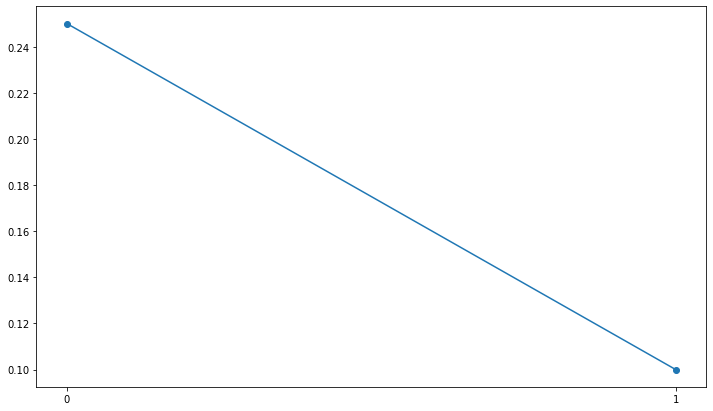

In [30]:
sigma = 1.0
bandit_instance = NormalBandit([0.25, 0.1], stds=[sigma, sigma])
plot_bandit(bandit_instance)

In [35]:
delta = 0.1

track_and_stop = ExplorationTaS(
    bandit_instance, 
    name="ExplorationTaS", 
    params={
        'init': 0,
        'sigma': sigma,
        'delta': delta,
    }
)

sequential_halving = ExplorationHalf(
    bandit_instance, 
    name="ExplorationHalf", 
    params={
        'init': 0, 
        'stopping criterion': 1500,
    }
)

In [36]:
expe = Experiment(
    [track_and_stop, sequential_halving],
    bandit_instance
)

In [37]:
expe.run(200)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/sauxpa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/home/sauxpa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log


  0%|          | 0/200 [00:00<?, ?it/s]

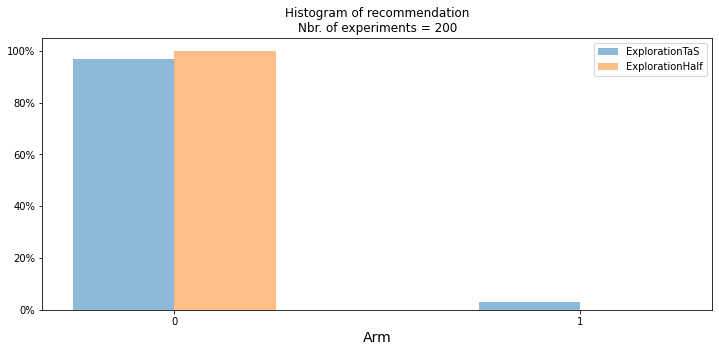

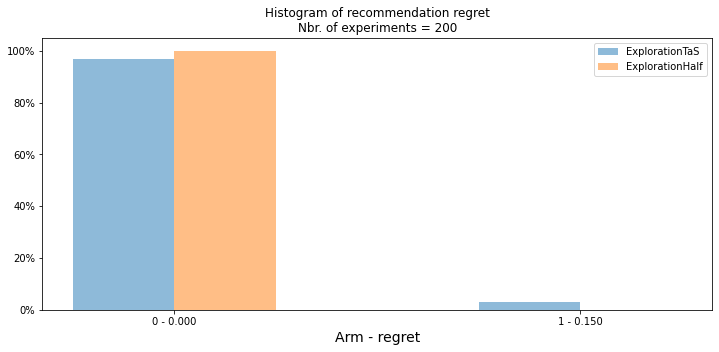

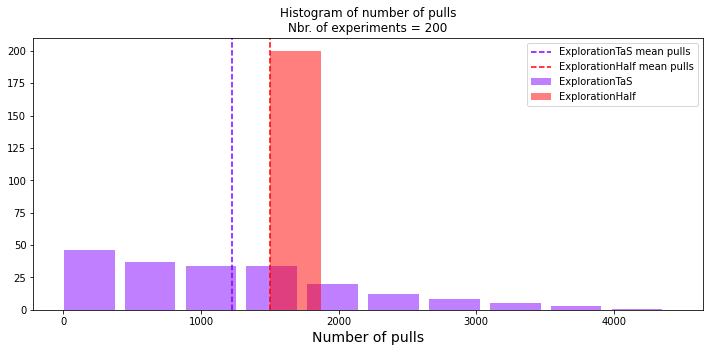

In [38]:
expe.plot(True)

## Question 9

Using the characteristic time $T_*(\mu)$, compute a lower bound on the sampling complexity $\mathbb{E}[\tau_\delta]$. 

Comment on the performances of Track-and-Stop. Do you know if the sample complexity of Track-and-Stop matches this lower bound? Is it what you observe in practice? If not, can you think of why?

Feel free to try different bandit problems as well.

In [41]:
gap = 0.25 - 0.1
characteristic_time = 1 / (gap ** 2 / (8 * sigma ** 2)) * np.log(1 / delta)
characteristic_time

818.6969219534385

### Question 10
Do you think using structure would help for BAI?

Answer: of course, it should help. Drawing inspiration from IMED for instance, one could use a sampling strategy to sample more in the neighborhood of the optimal arm, thus increasing exploration on the arms that are the closest to be optimal one (the most confusing arms for the identification task).